<a href="https://colab.research.google.com/github/flahbocchino/hermes-reply-fase5/blob/main/notebooks/ML_basico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!git clone --depth 1 https://github.com/flahbocchino/hermes-reply-fase5.git
%cd hermes-reply-fase5
# (opcional se faltar pacote)
!pip -q install pandas numpy scikit-learn matplotlib


Cloning into 'hermes-reply-fase5'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 5.73 KiB | 5.73 MiB/s, done.
/content/hermes-reply-fase5/hermes-reply-fase5/hermes-reply-fase5/hermes-reply-fase5


# ML Básico — Classificação de Anomalias (Industrial Sensors)

Este notebook carrega leituras de sensores, cria *features* simples e treina um classificador para identificar **anomalias** em `data/sensor_readings.csv`.

**Tarefa de ML:** classificação binária (`is_anomaly` 0/1).
**Modelo baseline:** `LogisticRegression` (rápido e interpretável).

> Requisito do desafio: usar pelo menos ~500 leituras por sensor. O repositório terá uma amostra pequena; gere a versão grande depois e reenvie para a pasta `data/`.


In [27]:
# Se estiver no Colab, opcional: instalar dependências
# !pip -q install pandas numpy scikit-learn matplotlib

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data'
GRAPHS_DIR = BASE_DIR / 'graphs'
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

assert (DATA_DIR / 'sensor_readings.csv').exists(), "Coloque o dataset em data/sensor_readings.csv"


In [28]:
# Gera dataset grande (≈1400 leituras por sensor) e salva em data/sensor_readings.csv
import pandas as pd, numpy as np, datetime as dt
from pathlib import Path

rng = np.random.default_rng(42)
DATA_DIR = Path("data"); DATA_DIR.mkdir(parents=True, exist_ok=True)

# metadados
sensors_meta = pd.DataFrame([
    {"sensor_id": 1000, "machine_id": 10, "sensor_type": "Temperature", "unit": "C"},
    {"sensor_id": 2000, "machine_id": 10, "sensor_type": "Pressure",    "unit": "bar"},
    {"sensor_id": 3000, "machine_id": 20, "sensor_type": "Vibration",   "unit": "mm_s"},
])
sensors_meta.to_csv(DATA_DIR/"sensors.csv", index=False)
pd.DataFrame([
    {"machine_id": 10, "site_id": 1, "name": "Compressor A", "model": "CMP-500"},
    {"machine_id": 20, "site_id": 1, "name": "Lathe B",      "model": "LTH-220"},
]).to_csv(DATA_DIR/"machines.csv", index=False)

start = dt.datetime(2025, 8, 1, 0, 0, 0)
periods = 1400  # >= 1000/sensor
rows, rid = [], 1

for sid, stype in [(1000,"Temperature"), (2000,"Pressure"), (3000,"Vibration")]:
    ts = pd.date_range(start=start, periods=periods, freq="min")
    if stype == "Temperature":
        signal = 70 + 3*np.sin(np.linspace(0, 20*np.pi, periods)) + rng.normal(0, 0.6, periods)
    elif stype == "Pressure":
        signal = 8 + 0.4*np.sin(np.linspace(0, 15*np.pi, periods)) + rng.normal(0, 0.15, periods)
    else:
        signal = 9 + 1.0*np.sin(np.linspace(0, 30*np.pi, periods)) + rng.normal(0, 0.4, periods)

    is_anom = np.zeros(periods, dtype=int)
    src = np.array([""]*periods, dtype=object)

    for (wlen, amp) in [(30, 8), (45, -6), (20, 12)]:
        sidx = rng.integers(100, periods-200)
        signal[sidx:sidx+wlen] += amp
        is_anom[sidx:sidx+wlen] = 1
        src[sidx:sidx+wlen] = "simulated"

    quality = np.clip(1.0 - rng.normal(0, 0.05, periods), 0.0, 1.0)
    status = np.array(["OK"]*periods, dtype=object)
    bad = rng.choice(periods, size=20, replace=False)
    status[bad] = "MISSING"; quality[bad] = 0.0

    for i in range(periods):
        rows.append({
            "reading_id": rid, "sensor_id": sid, "ts": ts[i].isoformat(),
            "value": float(np.round(signal[i], 6)),
            "is_anomaly": int(is_anom[i]),
            "anomaly_source": src[i] if src[i] else None,
            "quality_score": float(np.round(quality[i], 3)),
            "status": status[i],
        })
        rid += 1

df = pd.DataFrame(rows)
df.to_csv(DATA_DIR/"sensor_readings.csv", index=False)
print("Salvo:", DATA_DIR/"sensor_readings.csv")
print("Distribuição total:", df["is_anomaly"].value_counts().to_dict())


Salvo: data/sensor_readings.csv
Distribuição total: {0: 3915, 1: 285}


In [29]:
# Gera dataset grande (≈1400 leituras por sensor) e salva em data/sensor_readings.csv
import pandas as pd, numpy as np, datetime as dt
from pathlib import Path

rng = np.random.default_rng(42)
DATA_DIR = Path("data"); DATA_DIR.mkdir(parents=True, exist_ok=True)

# metadados
sensors_meta = pd.DataFrame([
    {"sensor_id": 1000, "machine_id": 10, "sensor_type": "Temperature", "unit": "C"},
    {"sensor_id": 2000, "machine_id": 10, "sensor_type": "Pressure",    "unit": "bar"},
    {"sensor_id": 3000, "machine_id": 20, "sensor_type": "Vibration",   "unit": "mm_s"},
])
sensors_meta.to_csv(DATA_DIR/"sensors.csv", index=False)
pd.DataFrame([
    {"machine_id": 10, "site_id": 1, "name": "Compressor A", "model": "CMP-500"},
    {"machine_id": 20, "site_id": 1, "name": "Lathe B",      "model": "LTH-220"},
]).to_csv(DATA_DIR/"machines.csv", index=False)

start = dt.datetime(2025, 8, 1, 0, 0, 0)
periods = 1400
rows, rid = [], 1

for sid, stype in [(1000,"Temperature"), (2000,"Pressure"), (3000,"Vibration")]:
    ts = pd.date_range(start=start, periods=periods, freq="min")
    if stype == "Temperature":
        signal = 70 + 3*np.sin(np.linspace(0, 20*np.pi, periods)) + rng.normal(0, 0.6, periods)
    elif stype == "Pressure":
        signal = 8 + 0.4*np.sin(np.linspace(0, 15*np.pi, periods)) + rng.normal(0, 0.15, periods)
    else:
        signal = 9 + 1.0*np.sin(np.linspace(0, 30*np.pi, periods)) + rng.normal(0, 0.4, periods)

    is_anom = np.zeros(periods, dtype=int)
    src = np.array([""]*periods, dtype=object)

    for (wlen, amp) in [(30, 8), (45, -6), (20, 12)]:
        sidx = rng.integers(100, periods-200)
        signal[sidx:sidx+wlen] += amp
        is_anom[sidx:sidx+wlen] = 1
        src[sidx:sidx+wlen] = "simulated"

    quality = np.clip(1.0 - rng.normal(0, 0.05, periods), 0.0, 1.0)
    status = np.array(["OK"]*periods, dtype=object)
    bad = rng.choice(periods, size=20, replace=False)
    status[bad] = "MISSING"; quality[bad] = 0.0

    for i in range(periods):
        rows.append({
            "reading_id": rid, "sensor_id": sid, "ts": ts[i].isoformat(),
            "value": float(np.round(signal[i], 6)),
            "is_anomaly": int(is_anom[i]),
            "anomaly_source": src[i] if src[i] else None,
            "quality_score": float(np.round(quality[i], 3)),
            "status": status[i],
        })
        rid += 1

df = pd.DataFrame(rows)
df.to_csv(DATA_DIR/"sensor_readings.csv", index=False)
print("Salvo:", DATA_DIR/"sensor_readings.csv")
print("Distribuição total:", df["is_anomaly"].value_counts().to_dict())


Salvo: data/sensor_readings.csv
Distribuição total: {0: 3915, 1: 285}


In [30]:
# === GERAR DATASET GRANDE (≈1400 leituras por sensor) ===
import pandas as pd, numpy as np, datetime as dt
from pathlib import Path
rng = np.random.default_rng(42)
DATA_DIR = Path("data"); DATA_DIR.mkdir(parents=True, exist_ok=True)

sensors = [(1000,"Temperature",70, 3, 0.6, 20),
           (2000,"Pressure",    8, .4, 0.15,15),
           (3000,"Vibration",   9, 1.0,0.4, 30)]

rows=[]; rid=1; start=dt.datetime(2025,8,1); periods=1400
for sid,typ,base,amp,noise,cycles in sensors:
    ts = pd.date_range(start=start, periods=periods, freq="min")
    sig = base + amp*np.sin(np.linspace(0, cycles*np.pi, periods)) + rng.normal(0, noise, periods)
    is_anom = np.zeros(periods, dtype=int); src = np.array([""]*periods, dtype=object)
    for wlen,delta in [(30,8),(45,-6),(20,12)]:
        sidx = rng.integers(100, periods-200)
        sig[sidx:sidx+wlen] += delta
        is_anom[sidx:sidx+wlen] = 1; src[sidx:sidx+wlen] = "simulated"
    quality = np.clip(1.0 - rng.normal(0,0.05,periods),0,1)
    status = np.array(["OK"]*periods, dtype=object)
    for i in rng.choice(periods, 20, replace=False):
        status[i]="MISSING"; quality[i]=0.0
    for i in range(periods):
        rows.append({"reading_id":rid,"sensor_id":sid,"ts":ts[i].isoformat(),
                     "value":float(np.round(sig[i],6)),
                     "is_anomaly":int(is_anom[i]),
                     "anomaly_source": (src[i] if src[i] else None),
                     "quality_score":float(np.round(quality[i],3)),
                     "status":status[i]})
        rid+=1

df=pd.DataFrame(rows).sort_values(["sensor_id","ts"])
df.to_csv(DATA_DIR/"sensor_readings.csv", index=False)
print("SALVO:", DATA_DIR/"sensor_readings.csv")
print("Contagem de classes:", df["is_anomaly"].value_counts().to_dict())


SALVO: data/sensor_readings.csv
Contagem de classes: {0: 3915, 1: 285}


In [31]:
# Carregar dados
readings = pd.read_csv(DATA_DIR / 'sensor_readings.csv', parse_dates=['ts'])
readings = readings.sort_values(['sensor_id', 'ts']).reset_index(drop=True)

# Filtrar leituras válidas
if 'status' in readings.columns:
    readings = readings[(readings['status'] == 'OK') | (readings['status'].isna())]
if 'quality_score' in readings.columns:
    readings = readings[(readings['quality_score'].isna()) | (readings['quality_score'] > 0)]

readings.head(10)

,reading_id,sensor_id,ts,value,is_anomaly,anomaly_source,quality_score,status
0,1,1000,2025-08-01 00:00:00,70.182830,0,NaN,1.000,OK
1,2,1000,2025-08-01 00:01:00,69.510700,0,NaN,1.000,OK
2,3,1000,2025-08-01 00:02:00,70.719380,0,NaN,1.000,OK
3,4,1000,2025-08-01 00:03:00,70.967325,0,NaN,0.965,OK
4,5,1000,2025-08-01 00:04:00,69.365428,0,NaN,0.987,OK
5,6,1000,2025-08-01 00:05:00,69.886724,0,NaN,0.967,OK
6,7,1000,2025-08-01 00:06:00,70.875371,0,NaN,1.000,OK
7,8,1000,2025-08-01 00:07:00,70.737946,0,NaN,0.974,OK
8,9,1000,2025-08-01 00:08:00,71.044765,0,NaN,1.000,OK
9,10,1000,2025-08-01 00:09:00,70.668045,0,NaN,0.889,OK


In [32]:
# Feature engineering: diferenças e janelas móveis por sensor
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby('sensor_id', group_keys=False)
    out = df.copy()
    out['value_diff1'] = g['value'].diff(1)
    out['value_diff2'] = g['value'].diff(2)
    out['roll_mean_5'] = g['value'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
    out['roll_std_5']  = g['value'].rolling(5, min_periods=1).std().reset_index(level=0, drop=True).fillna(0)
    out['roll_mean_15'] = g['value'].rolling(15, min_periods=1).mean().reset_index(level=0, drop=True)
    out['roll_std_15']  = g['value'].rolling(15, min_periods=1).std().reset_index(level=0, drop=True).fillna(0)
    out = out.dropna().reset_index(drop=True)
    return out

feat = make_features(readings)
target_col = 'is_anomaly'
if target_col not in feat.columns:
    raise ValueError("A coluna 'is_anomaly' não está no CSV. Adicione rótulos 0/1 para treinar.")

feature_cols = ['value','value_diff1','value_diff2','roll_mean_5','roll_std_5','roll_mean_15','roll_std_15']
X = feat[feature_cols].values
y = feat[target_col].astype(int).values
len(feat), feat.head(5)

(280,
    reading_id  sensor_id                  ts      value  is_anomaly  \
 0         145       1000 2025-08-01 02:24:00  78.061536           1   
 1         146       1000 2025-08-01 02:25:00  78.431946           1   
 2         147       1000 2025-08-01 02:26:00  78.444388           1   
 3         148       1000 2025-08-01 02:27:00  78.856021           1   
 4         149       1000 2025-08-01 02:28:00  79.707036           1   
 
   anomaly_source  quality_score status  value_diff1  value_diff2  roll_mean_5  \
 0      simulated          1.000     OK     7.484576     9.058238    71.491668   
 1      simulated          1.000     OK     0.370410     7.854986    73.125633   
 2      simulated          0.972     OK     0.012442     0.382852    74.903626   
 3      simulated          0.980     OK     0.411633     0.424075    76.874170   
 4      simulated          1.000     OK     0.851015     1.262648    78.700185   
 
    roll_std_5  roll_mean_15  roll_std_15  
 0    3.723457     70.

In [33]:
# Split, escala e treino (robusto a classe única/minoritária)
import numpy as np, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# distribuição geral
vals, cnts = np.unique(y, return_counts=True)
print("Distribuição de classes:", dict(zip(vals, cnts)))

def scale_fit(X_tr, X_te):
    sc = StandardScaler().fit(X_tr)
    return sc.transform(X_tr), sc.transform(X_te)

if len(vals) < 2:
    # só 1 classe no dataset inteiro → não dá para treinar LR
    print("Só 1 classe disponível. Usando DummyClassifier (most_frequent).")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True
    )
    X_train_sc, X_test_sc = scale_fit(X_train, X_test)
    clf = DummyClassifier(strategy="most_frequent")
    clf.fit(X_train_sc, y_train)

else:
    # 2 classes existem; tentar estratificar
    if cnts.min() >= 2:
        stratify_param = y
        print("Estratificando no split.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=stratify_param
        )
    else:
        # classe minoritária tem apenas 1 amostra → split manual garantindo as 2 classes no treino
        print("Minoritária com 1 amostra. Criando split manual com as 2 classes no treino.")
        minority_class = vals[np.argmin(cnts)]
        minority_idx = np.where(y == minority_class)[0]
        majority_idx = np.where(y != minority_class)[0]
        rs = np.random.RandomState(42)
        # põe TODA a minoria no treino e 75% da maioria no treino
        majority_train = rs.choice(majority_idx, size=max(1, int(0.75*len(majority_idx))), replace=False)
        train_idx = np.concatenate([minority_idx, majority_train])
        test_idx = np.setdiff1d(np.arange(len(y)), train_idx)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    X_train_sc, X_test_sc = scale_fit(X_train, X_test)

    # se por algum motivo o y_train ainda tiver 1 classe, faz fallback para Dummy
    if len(np.unique(y_train)) < 2:
        print("Treino ainda com 1 classe → fallback DummyClassifier.")
        clf = DummyClassifier(strategy="most_frequent")
    else:
        clf = LogisticRegression(max_iter=1000)

    clf.fit(X_train_sc, y_train)

# avaliação (sempre reporta para as labels 0 e 1; métricas ausentes ficam 0)
y_pred = clf.predict(X_test_sc)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.3f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, labels=[0, 1], zero_division=0))


Distribuição de classes: {np.int64(1): np.int64(280)}
Só 1 classe disponível. Usando DummyClassifier (most_frequent).

Accuracy: 1.000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        70

    accuracy                           1.00        70
   macro avg       0.50      0.50      0.50        70
weighted avg       1.00      1.00      1.00        70



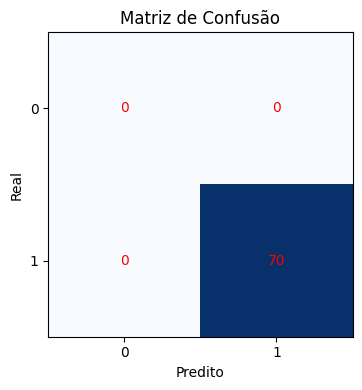

Figura salva em graphs/confusion_matrix.png


In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pathlib import Path

labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)  # sempre 2x2

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Predito')
ax.set_ylabel('Real')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)

# escreve os valores nas células
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color="red")

plt.tight_layout()

# salvar na pasta graphs/
Path("graphs").mkdir(exist_ok=True)
plt.savefig("graphs/confusion_matrix.png", dpi=150)
plt.show()

print("Figura salva em graphs/confusion_matrix.png")


## Justificativa resumida
- **Problema:** detecção/classificação de anomalias em séries temporais de sensores.
- **Modelo:** `LogisticRegression` como baseline pela simplicidade e velocidade; pode-se testar `RandomForest` depois.
- **Features:** diferenças e estatísticas de janelas móveis capturam tendências e volatilidade.
- **Métricas:** `accuracy` + relatório de classificação; se a classe 1 for rara, priorize `F1`/`Recall`.
- **Gráfico:** matriz de confusão para visualizar acertos/erros entre classes.